In [5]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pathlib

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.callbacks import ReduceLROnPlateau, EarlyStopping


import shutil
from sklearn.model_selection import train_test_split

In [12]:
dataset_url = "D:/Work/ricedata2"
data_dir = pathlib.Path(dataset_url)
image_count = len(list(data_dir.glob('*/*.[jJpP][pPnN][gG]')))
print(image_count)

9874


In [9]:
split_dirs = ["train", "val", "test"]

In [16]:
base_split_dir = "D:/Work/ricedata2_split"

categories = ["browon_spot", "leaf_scaled", "rice_blast", "rice_turgro", "sheath_blight"]

# Create directories for train, val, and test splits
for split_dir in split_dirs:
    for category in categories:
        os.makedirs(os.path.join(base_split_dir, split_dir, category), exist_ok=True)

In [17]:
def move_images(image_list, destination):
    for image in image_list:
        shutil.copy(str(image), os.path.join(base_split_dir, destination, category, image.name))

In [18]:

for category in categories:
    category_path = data_dir / category
    images = list(category_path.glob('*.*'))  # ดึงไฟล์ทุกประเภท เช่น .jpg, .png
    
    # ตรวจสอบว่ามีภาพในโฟลเดอร์หรือไม่
    print(f"Found {len(images)} images in category: {category}")  # เพิ่มการตรวจสอบว่ามีภาพเท่าไหร่ในแต่ละโฟลเดอร์

    if len(images) == 0:
        print(f"No images found in category: {category}")
        continue  # ข้ามหมวดหมู่ที่ไม่มีภาพ

    # แบ่งข้อมูลเป็น train (80%) และ temp (20%)
    train_images, temp_images = train_test_split(images, test_size=0.2, random_state=142)

    # แบ่ง temp เป็น val (10%) และ test (10%)
    val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=142)

    # ย้ายภาพไปยัง directory ที่ถูกต้อง
    move_images(train_images, "train")
    move_images(val_images, "val")
    move_images(test_images, "test")

Found 1739 images in category: browon_spot
Found 2056 images in category: leaf_scaled
Found 2163 images in category: rice_blast
Found 2050 images in category: rice_turgro
Found 1866 images in category: sheath_blight


In [19]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [22]:
val_test_datagen = ImageDataGenerator(rescale=1./255)
train_dir = os.path.join(base_split_dir, "train")
val_dir = os.path.join(base_split_dir, "val")
test_dir = os.path.join(base_split_dir, "test")

In [28]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='categorical',
    classes=categories
)

Found 7897 images belonging to 5 classes.


In [27]:
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='categorical',
    classes=categories
)

Found 988 images belonging to 5 classes.


In [26]:
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=64,
    class_mode='categorical',
    classes=categories
)

Found 989 images belonging to 5 classes.


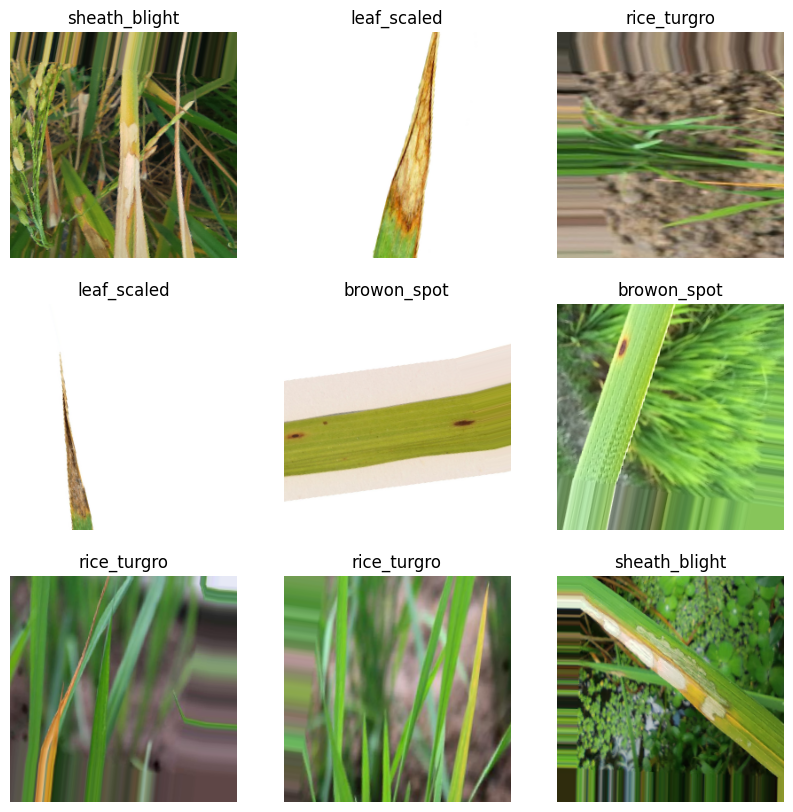

In [30]:
images, labels = next(train_generator)
class_names = list(train_generator.class_indices.keys())

# Set up the plot
plt.figure(figsize=(10, 10))

# Plot 9 images
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[labels[i].argmax()])
    plt.axis("off")

plt.show()

In [31]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

def create_cnn_model(input_shape, num_classes):
    model = Sequential()

    # Input Layer
    model.add(Input(shape=input_shape))

    # Convolutional Layers
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Flatten the output
    model.add(Flatten())

    # Fully Connected Layer
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    return model

In [33]:
input_shape = (256, 256, 3)  # Image size (height, width, channels)
num_classes = len(categories)  # Number of classes

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Create and compile the model
model = create_cnn_model(input_shape, num_classes)
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [34]:
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/100
 20/124 [===>..........................] - ETA: 1:49 - loss: 1.7054 - accuracy: 0.2570

KeyboardInterrupt: 

In [ ]:
https://www.kaggle.com/code/yaminh/rice-diseases-with-tf-cnn-acc-0-975